In [1]:
import pandas as pd
import numpy as np

import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [4]:
stats_years=pd.read_pickle('../Merged DFs/team_annual_statistics.pkl')
game_data=pd.read_pickle('../Merged DFs/Games_AllData.pkl')

In [5]:
game_data.columns

Index(['Away_Team', 'Home_Team', 'Away_Score', 'Home_Score', 'link', 'date',
       'KEY', 'CloseOU', 'Close_Odds', 'year', 'month', 'Home_Pitcher',
       'Away_Pitcher', 'OVER', 'Total_Runs', 'day_or_night', 'attendance',
       'cli', 'other', 'Away_Pitcher_Name', 'Away_Pitcher_ID',
       'Home_Pitcher_Name', 'Home_Pitcher_ID'],
      dtype='object')

In [6]:
Away_Stats=game_data.apply(lambda r:stats_years.loc[(r.Away_Team,str(r.year-1)),:],axis=1)
Home_Stats=game_data.apply(lambda r:stats_years.loc[(r.Home_Team,str(r.year-1)),:],axis=1)

In [7]:
stats=pd.merge(Away_Stats,Home_Stats,left_index=True,right_index=True,suffixes=['_A','_H'])

In [8]:
stats

,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,HR_A,RBI_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
0,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,0.197531,1.086420,3.975309,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
1,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,0.197531,1.086420,3.975309,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
2,48.0,27.8,37.444444,33.623457,4.271605,8.524691,1.790123,0.234568,0.969136,4.104938,...,0.858025,0.26,0.903,1.154321,0.635802,0.685,1084.0,0.984,-3.0,1.0
3,51.0,26.5,37.475309,34.092593,4.049383,8.222222,1.598765,0.246914,1.123457,3.944444,...,0.703704,0.37,0.991,0.820988,0.462963,0.680,1234.0,0.987,-2.0,-4.0
4,49.0,29.2,38.006173,33.703704,4.277778,7.919753,1.598765,0.308642,1.086420,4.061728,...,1.061728,0.24,1.009,0.783951,0.709877,0.698,910.0,0.983,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,45.0,29.0,36.901235,33.302469,3.672840,7.913580,1.567901,0.123457,0.808642,3.469136,...,1.012346,0.36,1.078,0.493827,0.561728,0.694,1043.0,0.983,3.0,-4.0
12112,45.0,29.6,38.549383,34.228395,4.500000,8.358025,1.561728,0.203704,0.901235,4.234568,...,0.956790,0.27,1.002,0.783951,0.537037,0.712,1136.0,0.986,3.0,-5.0
12113,49.0,27.3,38.049383,34.641975,4.660494,9.574074,1.895062,0.253086,1.148148,4.450617,...,0.925926,0.30,0.969,0.672840,0.629630,0.703,1054.0,0.984,4.0,-1.0
12114,55.0,29.2,38.067901,34.253086,4.462963,8.858025,1.740741,0.148148,1.092593,4.259259,...,0.839506,0.26,1.022,0.759259,0.691358,0.700,1108.0,0.985,-2.0,-6.0


In [9]:
dataset=pd.merge(game_data[['OVER','month','CloseOU']],stats,left_index=True,right_index=True)

In [10]:
dataset

,OVER,month,CloseOU,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
0,True,3,8.5,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
1,False,3,9.0,53.0,29.8,37.574074,34.030864,4.179012,8.654321,1.580247,...,0.987654,0.35,0.982,0.987654,0.716049,0.717,1116.0,0.985,4.0,0.0
2,False,3,8.5,48.0,27.8,37.444444,33.623457,4.271605,8.524691,1.790123,...,0.858025,0.26,0.903,1.154321,0.635802,0.685,1084.0,0.984,-3.0,1.0
3,False,3,8.5,51.0,26.5,37.475309,34.092593,4.049383,8.222222,1.598765,...,0.703704,0.37,0.991,0.820988,0.462963,0.680,1234.0,0.987,-2.0,-4.0
4,True,3,7.0,49.0,29.2,38.006173,33.703704,4.277778,7.919753,1.598765,...,1.061728,0.24,1.009,0.783951,0.709877,0.698,910.0,0.983,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,False,10,7.5,45.0,29.0,36.901235,33.302469,3.672840,7.913580,1.567901,...,1.012346,0.36,1.078,0.493827,0.561728,0.694,1043.0,0.983,3.0,-4.0
12112,False,10,7.5,45.0,29.6,38.549383,34.228395,4.500000,8.358025,1.561728,...,0.956790,0.27,1.002,0.783951,0.537037,0.712,1136.0,0.986,3.0,-5.0
12113,True,10,7.5,49.0,27.3,38.049383,34.641975,4.660494,9.574074,1.895062,...,0.925926,0.30,0.969,0.672840,0.629630,0.703,1054.0,0.984,4.0,-1.0
12114,True,10,8.5,55.0,29.2,38.067901,34.253086,4.462963,8.858025,1.740741,...,0.839506,0.26,1.022,0.759259,0.691358,0.700,1108.0,0.985,-2.0,-6.0


In [11]:
dataset.describe()

,month,CloseOU,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
count,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,...,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000,12116.000000
mean,6.540773,8.568381,49.512545,28.324975,37.966287,34.060719,4.377699,8.609798,1.699421,0.177119,...,0.911996,0.299602,0.989998,0.760320,0.645457,0.689369,1105.656983,0.984232,0.028557,-0.250908
std,1.742216,1.144460,4.759812,1.063362,0.574640,0.414608,0.433614,0.412021,0.153047,0.057488,...,0.139161,0.040013,0.042853,0.173470,0.120450,0.011083,56.319408,0.002214,3.021373,5.183335
min,3.000000,5.000000,39.000000,25.400000,36.450617,32.679012,3.302469,7.401235,1.370370,0.030864,...,0.580247,0.200000,0.860000,0.444444,0.358025,0.662000,910.000000,0.978000,-8.000000,-14.000000
25%,5.000000,8.000000,46.000000,27.700000,37.487654,33.777778,4.043210,8.327160,1.586420,0.135802,...,0.820988,0.280000,0.963000,0.641975,0.567901,0.682000,1077.000000,0.983000,-2.000000,-4.000000
50%,7.000000,8.500000,49.000000,28.300000,37.962963,34.061728,4.358025,8.623457,1.697531,0.179012,...,0.901235,0.300000,0.989000,0.743827,0.629630,0.688000,1112.000000,0.984000,0.000000,-1.000000
75%,8.000000,9.000000,52.000000,28.900000,38.413580,34.296296,4.660494,8.864198,1.783951,0.209877,...,1.006173,0.320000,1.015000,0.864198,0.734568,0.697000,1144.000000,0.986000,2.000000,3.000000
max,10.000000,15.000000,64.000000,32.800000,39.314815,35.000000,5.530864,9.864198,2.191358,0.345679,...,1.345679,0.400000,1.101000,1.444444,0.913580,0.728000,1234.000000,0.989000,9.000000,14.000000


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12116 entries, 0 to 12115
Columns: 119 entries, OVER to Rgood_H
dtypes: bool(1), float64(117), int64(1)
memory usage: 11.3 MB


In [13]:
X=dataset.drop('OVER',axis=1)
y=dataset.OVER
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1988)

In [14]:
X_train.index

Int64Index([ 6349,  5672,  4856, 10535,  8360,  6068,   351,  7969,  6044,
             4539,
            ...
             8107, 11891,   869, 12032, 11069,   936,  6961,  6709,  3048,
            10093],
           dtype='int64', length=9087)

In [15]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)
X_train

,month,CloseOU,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
6349,0.271969,-0.066053,-0.103468,-1.343652,1.006523,1.488001,0.178522,0.211159,0.493518,0.683861,...,1.392998,-0.489628,-0.588055,0.107729,1.978271,0.865845,-0.819928,0.788177,0.647135,-0.721767
5672,-0.301704,0.369524,-1.358480,0.448780,0.533318,-0.416749,0.763546,0.121232,-0.311212,0.039219,...,-0.616087,-0.489628,-0.658443,1.179050,-0.436337,-0.399009,0.287078,-0.117738,-1.680332,-0.914585
4856,-1.449049,-0.066053,0.942376,2.052535,0.812939,0.967171,0.834890,0.765707,-0.995233,-1.250066,...,0.812596,0.261977,-0.024950,-0.392220,-0.898708,-0.760396,-0.070021,1.241134,-0.350351,-1.300221
10535,-0.301704,-1.372784,-0.730974,0.165765,-0.703467,-1.369124,-1.291172,-0.358378,-0.029556,-0.820305,...,0.321486,-1.241232,0.467767,-1.070723,0.180159,0.052725,-0.569959,-0.570695,0.314639,0.049504
8360,-0.301704,-0.066053,-0.312637,0.543119,0.017095,0.699315,-0.192469,1.365219,0.493518,1.113623,...,0.946535,-2.243371,2.086694,-1.284988,1.002153,-0.941089,-1.998355,-1.476610,-0.350351,-0.914585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,-0.301704,-0.937207,0.524038,-0.211589,2.221799,0.803481,1.348570,-0.013658,0.815411,0.468980,...,0.142901,0.261977,1.148186,-0.713617,-0.230838,0.233418,0.090674,-0.117738,-0.017856,1.206411
6961,1.419314,0.805101,1.779050,-0.211589,-1.617613,-1.473290,-0.335158,-1.797207,-0.753814,-0.283103,...,-0.750026,1.765185,0.444304,-0.392220,1.310401,-2.205943,-0.016456,-0.570695,-1.015342,2.170500
6709,0.845642,1.240678,0.942376,2.052535,0.812939,0.967171,0.834890,0.765707,-0.995233,-1.250066,...,-0.839319,0.261977,0.092364,0.357704,1.259026,0.233418,1.036986,-0.570695,0.314639,-1.493039
3048,-0.875376,-0.501630,0.524038,-0.400267,0.425772,-1.636980,0.863428,-0.718085,1.459195,-0.927745,...,0.678657,1.765185,-0.376891,-0.142245,0.796655,0.143071,1.054841,1.694091,-0.017856,1.592047


In [16]:
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)
X_test

,month,CloseOU,#Bat_A,BatAge_A,PA_A,AB_A,R_A,H_A,2B_A,3B_A,...,SVSit_H,IS%_H,aLI_H,IPmult_H,0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
11212,0.271969,0.369524,-0.312637,1.392166,0.544073,1.666571,0.677933,2.429353,1.982270,-0.283103,...,1.035827,-1.241232,1.523589,1.000497,-0.641835,1.498272,0.322788,0.788177,1.312125,1.399229
81,-1.449049,-1.808362,0.314869,-1.721006,-0.864787,0.074319,-0.763224,-0.942902,-0.673341,1.221063,...,-0.437502,-0.740162,0.045438,0.179151,0.848029,-0.127969,-0.748509,0.788177,-0.350351,0.242322
10613,-0.301704,-0.937207,-0.103468,2.241212,0.501054,1.264788,-1.291172,-0.583195,-0.995233,-0.175662,...,0.723303,1.514650,2.063231,-1.534962,-0.693210,0.414111,-1.123462,-0.570695,0.979630,-0.721767
10910,0.271969,-0.066053,-0.312637,-2.758730,-1.036861,-1.056626,-1.148484,-1.167719,-1.437835,-1.035185,...,-1.107197,0.011442,0.186214,-0.535063,0.180159,-0.399009,0.537047,0.335219,0.314639,-1.107403
3426,-0.301704,-0.066053,-1.776818,-0.022912,0.533318,0.238009,1.633947,1.724927,0.694701,1.006182,...,-0.616087,0.512511,-0.423816,-0.177956,0.539781,-0.579702,0.465628,0.788177,-1.015342,-0.143314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,-0.301704,1.676255,-0.312637,-1.532329,-0.165734,-1.398886,-0.463578,-1.872146,-1.397598,0.146659,...,0.634010,0.512511,0.772782,-0.535063,-0.641835,1.769312,1.072696,0.788177,1.312125,-0.143314
4889,-1.449049,0.369524,0.942376,2.052535,0.812939,0.967171,0.834890,0.765707,-0.995233,-1.250066,...,0.812596,0.261977,-0.024950,-0.392220,-0.898708,-0.760396,-0.070021,1.241134,-0.350351,-1.300221
11909,1.419314,-0.937207,-1.149312,-0.588944,-0.800259,0.371936,-0.706148,0.076268,0.131390,0.361540,...,-0.124977,-2.493905,1.922455,1.036207,2.235144,-1.483169,0.840581,-1.476610,-1.347837,1.013593
10032,-0.875376,-0.937207,-0.940143,-0.966298,0.780675,0.267770,-0.392233,0.615829,-0.029556,0.146659,...,1.035827,-1.742301,2.602874,-0.642195,0.745280,1.046538,-0.212860,0.335219,0.979630,1.206411


In [17]:
log_model=LogisticRegression(random_state=1988,max_iter=1000)
log_model.fit(X_train,y_train)
log_model.score(X_train,y_train)

0.5569494882799604

In [18]:
log_results=ModelWithCV(log_model,'simple_log',X_train,y_train)

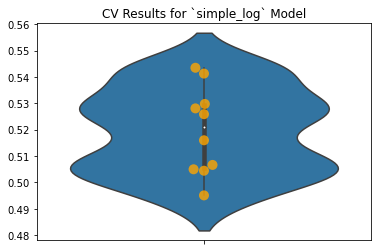

In [19]:
log_results.cv_results
fig,ax=plt.subplots()
ax=log_results.plot_cv(ax)
plt.plot();

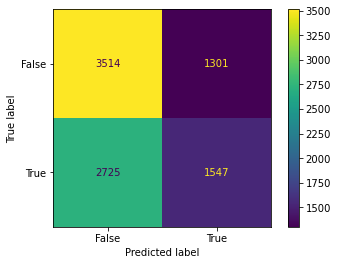

In [20]:
plot_confusion_matrix(log_model,X_train,y_train)

In [21]:
print(classification_report(y_test,log_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.69      0.60      1589
        True       0.49      0.33      0.39      1440

    accuracy                           0.52      3029
   macro avg       0.51      0.51      0.50      3029
weighted avg       0.51      0.52      0.50      3029



In [22]:
param_grid={
    'max_iter':[500,1000,2000],
    'penalty':['l1','l2','none'],
    'solver':['liblinear','lbfgs'],
}

In [23]:
grid_logistic=GridSearchCV(LogisticRegression(random_state=1988),param_grid,cv=5,scoring='accuracy',verbose=1,n_jobs=-1)

In [24]:
grid_logistic.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished
/Users/george/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1988), n_jobs=-1,
             param_grid={'max_iter': [500, 1000, 2000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [39]:
print(grid_logistic.best_score_)
print(grid_logistic.best_params_)
print(grid_logistic.best_estimator_)
dict(zip(X_train.columns.values,grid_logistic.best_estimator_.coef_[0]))

0.5250373413786068
{'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
LogisticRegression(max_iter=500, penalty='none', random_state=1988)


{'month': 0.007333604126954191,
 'CloseOU': -0.10081052422696882,
 '#Bat_A': 0.052575876884372645,
 'BatAge_A': 0.039539227991777795,
 'PA_A': -0.8173087217826625,
 'AB_A': 0.3873455138284138,
 'R_A': 0.4143055363386354,
 'H_A': 0.744206138080802,
 '2B_A': 0.08807066600732492,
 '3B_A': 0.0632547940173792,
 'HR_A': -0.14050440047659338,
 'RBI_A': -0.5647006406121532,
 'SO_A': 0.10202408407358583,
 'BA_A': 0.13273448350191253,
 'OPS+_A': 0.7215300735416027,
 'GDP_A': -0.011246040262303266,
 'LO_A': 0.03744295513849785,
 'Steal Attempts_A': -0.06126355715542191,
 'Sacs_A': 0.12693793069937373,
 'Free_Bases_A': 0.7035252648491217,
 'AIR_A': -0.32407696975584965,
 'BAbip_A': -0.5313907242718434,
 'OWn%_A': -0.032953475916688756,
 'BtRuns_A': -0.8587073283390328,
 'PwrSpd_A': 0.023310782022031584,
 '#P_A': -0.030125903603160125,
 'PAge_A': -0.013679832506537965,
 'RA/G_A': 0.6524414954501373,
 'CG_A': 0.039599942974421695,
 'tSho_A': 0.015077257941635423,
 'cSho_A': 0.011637748780670793,
 'I

In [40]:
print(classification_report(y_test,grid_logistic.best_estimator_.predict(X_test)))


              precision    recall  f1-score   support

       False       0.54      0.68      0.60      1589
        True       0.50      0.35      0.41      1440

    accuracy                           0.52      3029
   macro avg       0.52      0.52      0.51      3029
weighted avg       0.52      0.52      0.51      3029



In [48]:
param_grid = { 
    'n_estimators': [300,400,600],
    'min_samples_leaf':[25,50],
    'max_leaf_nodes':range(50,75,5),
    'max_features' :['auto', 5,6]
}

In [52]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [53]:
grid_forest.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 12.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 5, 6],
                         'max_leaf_nodes': range(50, 75, 5),
                         'min_samples_leaf': [25, 50],
                         'n_estimators': [300, 400, 600]},
             scoring='accuracy', verbose=1)

In [54]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)
print(grid_forest.best_estimator_.feature_importances_)

0.526133939756111
{'max_features': 6, 'max_leaf_nodes': 50, 'min_samples_leaf': 25, 'n_estimators': 400}
RandomForestClassifier(max_features=6, max_leaf_nodes=50, min_samples_leaf=25,
                       n_estimators=400)
[0.00756672 0.01454236 0.00574154 0.0091307  0.01031195 0.01159294
 0.00960093 0.01061944 0.01043863 0.0085069  0.00958731 0.00923919
 0.01048592 0.00727547 0.00927778 0.00760152 0.00747388 0.01146929
 0.00958252 0.01065014 0.01025514 0.00839192 0.00926805 0.01114481
 0.01267264 0.00516348 0.00735227 0.00989058 0.00383252 0.00729127
 0.00240021 0.00928163 0.01190697 0.00976547 0.0117501  0.00864259
 0.00247708 0.00977613 0.00923214 0.00854973 0.00808384 0.00741707
 0.00738554 0.00377334 0.00238807 0.00871819 0.00457792 0.00400826
 0.00697215 0.00683383 0.00856745 0.00576596 0.01443625 0.00845498
 0.00844538 0.00947654 0.01005553 0.00504301 0.00651761 0.00575918
 0.0071017  0.00843527 0.01067142 0.0111561  0.00874656 0.01000872
 0.01073847 0.00800385 0.00891729 0.00

In [55]:
dict(zip(X_test.columns,grid_forest.best_estimator_.feature_importances_))

{'month': 0.007566719045765439,
 'CloseOU': 0.014542356020649062,
 '#Bat_A': 0.005741537607809422,
 'BatAge_A': 0.00913069799121012,
 'PA_A': 0.010311950081696638,
 'AB_A': 0.011592942480308795,
 'R_A': 0.009600934927102673,
 'H_A': 0.010619444488916455,
 '2B_A': 0.010438627198499644,
 '3B_A': 0.008506899234760482,
 'HR_A': 0.009587310872836773,
 'RBI_A': 0.009239188004930338,
 'SO_A': 0.011906974926768944,
 'BA_A': 0.007275472284641796,
 'OPS+_A': 0.009277781243860968,
 'GDP_A': 0.007601524816821847,
 'LO_A': 0.007473882460614798,
 'Steal Attempts_A': 0.011469294425019136,
 'Sacs_A': 0.009582519890319871,
 'Free_Bases_A': 0.01065014302743205,
 'AIR_A': 0.010255140853422863,
 'BAbip_A': 0.008391921057525837,
 'OWn%_A': 0.009268053456683484,
 'BtRuns_A': 0.01114481415671511,
 'PwrSpd_A': 0.012672636633587246,
 '#P_A': 0.005163478309232393,
 'PAge_A': 0.007352265597553083,
 'RA/G_A': 0.009890579136414992,
 'CG_A': 0.010055531257018444,
 'tSho_A': 0.0072912664967276775,
 'cSho_A': 0.00240

In [56]:
print(classification_report(y_test,grid_forest.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.78      0.63      1589
        True       0.50      0.25      0.33      1440

    accuracy                           0.53      3029
   macro avg       0.52      0.51      0.48      3029
weighted avg       0.52      0.53      0.49      3029



In [64]:
param_grid = { 
    'n_estimators': [500,700,800],
    'min_samples_leaf':[75,80,90],
    'max_leaf_nodes':range(75,100,5),
    'max_features' :['auto', 5,6]
}

In [65]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [66]:
grid_forest.fit(X_train,y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 26.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 5, 6],
                         'max_leaf_nodes': range(75, 100, 5),
                         'min_samples_leaf': [75, 80, 90],
                         'n_estimators': [500, 700, 800]},
             scoring='accuracy', verbose=1)

In [67]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)
print(grid_forest.best_estimator_.feature_importances_)

0.525145354381338
{'max_features': 5, 'max_leaf_nodes': 85, 'min_samples_leaf': 80, 'n_estimators': 500}
RandomForestClassifier(max_features=5, max_leaf_nodes=85, min_samples_leaf=80,
                       n_estimators=500)
[0.00665742 0.01436272 0.00596487 0.0089629  0.0099644  0.00923143
 0.0099557  0.01098714 0.0109919  0.00812191 0.00892526 0.00949959
 0.0095879  0.00804547 0.00840783 0.00831624 0.0072638  0.01087872
 0.00819988 0.01125608 0.01049032 0.00832872 0.01031929 0.01102481
 0.01129679 0.00548356 0.00665009 0.01048992 0.00439676 0.00697305
 0.00262957 0.01077623 0.01263079 0.00894741 0.01222348 0.00938313
 0.00448827 0.00910689 0.0107579  0.00758573 0.00691229 0.00773959
 0.00721385 0.00397775 0.00254249 0.00853669 0.00666127 0.00448453
 0.00692863 0.00681389 0.00998135 0.00650442 0.01362982 0.00825467
 0.01179997 0.00782917 0.01027186 0.00533091 0.00716061 0.00720543
 0.00688102 0.00908441 0.00973849 0.0112147  0.0109653  0.00898638
 0.01005074 0.00794209 0.00998646 0.00

In [68]:
dict(zip(X_test.columns,grid_forest.best_estimator_.feature_importances_))

{'month': 0.0066574227338731095,
 'CloseOU': 0.01436271519384023,
 '#Bat_A': 0.005964869248325186,
 'BatAge_A': 0.008962899761999566,
 'PA_A': 0.009964397337885475,
 'AB_A': 0.009231434513862323,
 'R_A': 0.009955696722633576,
 'H_A': 0.010987143716345498,
 '2B_A': 0.010991900848071258,
 '3B_A': 0.008121908046829702,
 'HR_A': 0.008925262041885458,
 'RBI_A': 0.009499586546145739,
 'SO_A': 0.0126307905768664,
 'BA_A': 0.008045473262533348,
 'OPS+_A': 0.008407826753742598,
 'GDP_A': 0.008316238886088448,
 'LO_A': 0.007263798342735566,
 'Steal Attempts_A': 0.010878718676211402,
 'Sacs_A': 0.008199880701627993,
 'Free_Bases_A': 0.011256080035480712,
 'AIR_A': 0.010490316016236645,
 'BAbip_A': 0.008328715019244884,
 'OWn%_A': 0.010319288317293165,
 'BtRuns_A': 0.011024813405463312,
 'PwrSpd_A': 0.011296792699974524,
 '#P_A': 0.005483557698398243,
 'PAge_A': 0.006650087435938973,
 'RA/G_A': 0.01048992233475215,
 'CG_A': 0.01027185746252234,
 'tSho_A': 0.00697304764871493,
 'cSho_A': 0.00262956

In [69]:
print(classification_report(y_test,grid_forest.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

       False       0.53      0.81      0.65      1589
        True       0.52      0.22      0.31      1440

    accuracy                           0.53      3029
   macro avg       0.53      0.52      0.48      3029
weighted avg       0.53      0.53      0.48      3029

